# 線形回帰の Bayes推論
- Data: Iris-dataset
- 概要: 同じ花の種類同士で比較した場合、４つの項目値の間には正の相関があり、最も簡単な近似として、**２つの項目間の関係は1次関数で近似できる。** という仮説を前提として１次関数の傾きと切片の取り得る値を Bayes推論で確率的に調べる。
- 問題: `versicolor` という花の `sepal_length` と `sepal_width` の関係を1次関数近似し、２つの項目の観測値の関係性を示す Parameter を Bayes推論で求める。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Data準備
df = sns.load_dataset('iris')  # Iris-dataset の読み込み
display(df['species'].value_counts())  # species の分布確認
df

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [4]:
# 分析対象 Data の抽出
df_versicolor = df[df['species'] == 'versicolor']

# sepal_length と sepal_width の列を抽出
x_sepal_length = df_versicolor['sepal_length']
y_sepal_width  = df_versicolor['sepal_width']

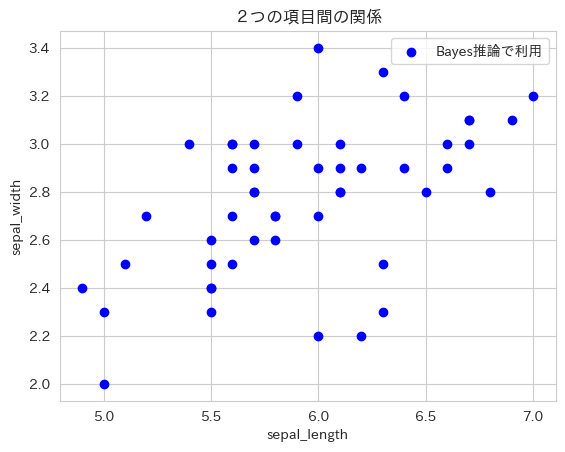

In [5]:
# 分析対象項目間の散布図表示
plt.title('２つの項目間の関係')
plt.scatter(x_sepal_length, y_sepal_width, label='Bayes推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

仮説どおり、２つの項目間には正の相関がありそうなことを確認。
この関係性を１次関数で近似するうことを Bayes推論で進めていく。

$$
Y_n = \alpha X_n + \beta + \epsilon_n
$$

という数式で `sepal_length` と `sepal_width` ２つの変数列の間で１次近似が可能であることを表現できる。
誤差 $\epsilon_n$ は標準偏差 epsilon の正規分布に従うという仮定をおく。

In [6]:
# 線形回帰の確率 Model 定義
model_lr = pm.Model()

with model_lr:
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)  # 確率変数 alpha(１次関数の傾き)を定義
    beta  = pm.Normal('beta', mu=0.0, sigma=10.0)   # 確率変数 beta (１次関数の切片)を定義
    
    mu = alpha * x_sepal_length + beta  # 平均値 mu の計算
    
    epsilon = pm.HalfNormal('epsilon', sigma=10.0)  # 誤差を示す確率変数の定義
    
    # 観測値を持つ確率変数を定義
    y_obs_sepal_width = pm.Normal('y_obs_sepal_width', mu=mu, sigma=epsilon, observed=y_sepal_width)

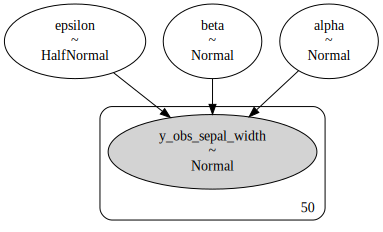

In [7]:
# 確率 Model 構造の可視化
g = pm.model_to_graphviz(model_lr)
g

`y_sepal_width` と並んで重要な観測値 `x_sepal_length` が可視化結果にでてきていない為、改善する。

In [8]:
# 上記改善点を踏まえて線形回帰の確率 Model を再定義
model_lr = pm.Model()

with model_lr:
    # 観測値 x_sepal_length, y_sepal_width を ConstantData として定義
    x_data_sepal_length = pm.ConstantData('x_data_sepal_length', x_sepal_length)
    y_data_sepal_width  = pm.ConstantData('y_data_sepal_width', y_sepal_width)

    # 確率変数 alpha(１次関数の傾き), beta(１次関数の切片) の定義
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta = pm.Normal('beta', mu=0.0, sigma=10.0)

    # 平均値 mu の計算
    mu = pm.Deterministic('mu', alpha * x_data_sepal_length + beta)

    # 誤差を示す確率変数 epsilon の定義
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # 観測値を持つ確率変数は y_obs_sepal_width として定義
    y_obs_sepal_width = pm.Normal('y_obs_sepal_width', mu=mu, sigma=epsilon, observed=y_data_sepal_width)

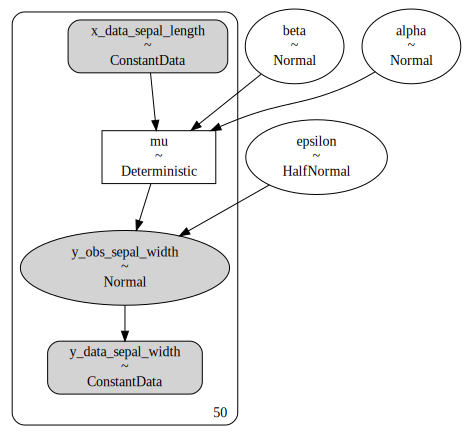

In [9]:
pm.model_to_graphviz(model_lr)

> `pm.ConstantData`  Class:  定数Data を PyMC で表現するための Class
> `pm.Deterministic` Class: 計算の途中経過の確率変数を表現するための Class

- Bayes推論の対象となる確率変数は `alpha`, `beta`, `epsilon` の３つ（丸い Icon）
- `x_data_sepal_length` と `y_data_sepal_width` は観測値に基づく定数Data(角が丸い四角の Icon)
- `mu` の計算には、`x_data_sepal_length` と `alpha`, `beta` が用いられる（計算で導出される確率変数は四角の Icon）
- `x_data_sepal_length`, `y_data_sepal_width`, `mu`, `y_obs_sepal_width` はそれぞれ要素数が 50 の配列
- 正規分布の確率変数 `y_obs_sepal_width` の生成には `mu` と `epsilon` が Parameter として用いられている
- 正規分布の確率変数 `y_obs_sepal_width` は、`y_data_sepal_width` を観測値として用いている

In [14]:
# Sampling
with model_lr:
    idata = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


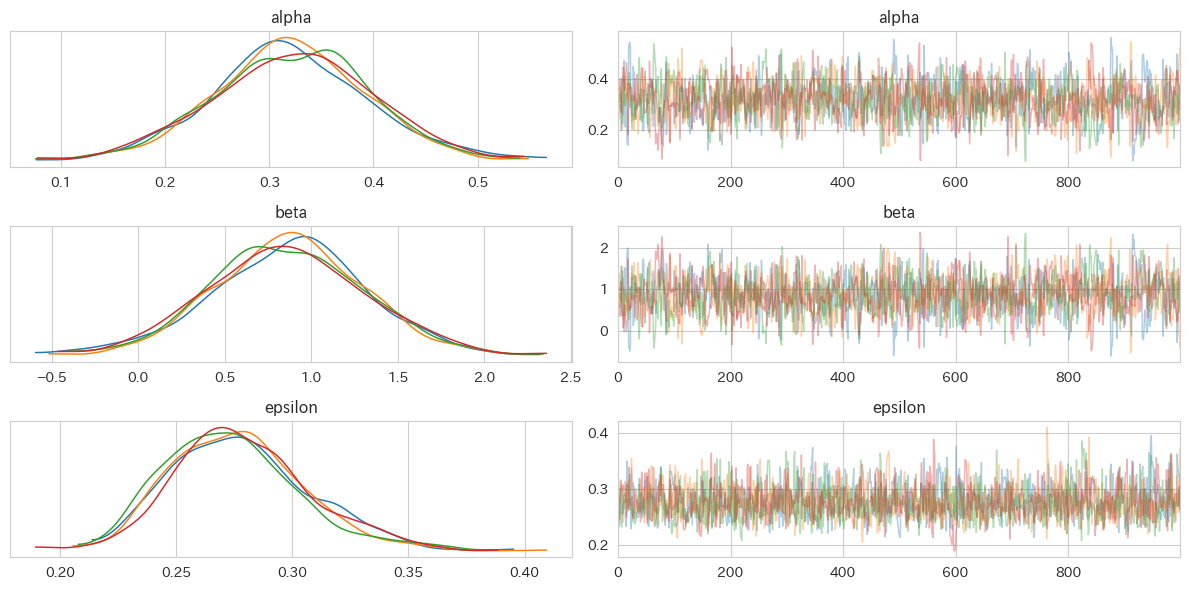

In [15]:
# Sampling の正常性を確認
az.plot_trace(idata, compact=False, var_names=['alpha', 'beta', 'epsilon'])  # mu は表示不要
plt.tight_layout()
plt.show()

- 各 Sample値系列の Graph の形状にほぼ違いなし。
- 各値の分布は均等にばらけている様子。

以上から、Bayes推論は正しくできていると判断

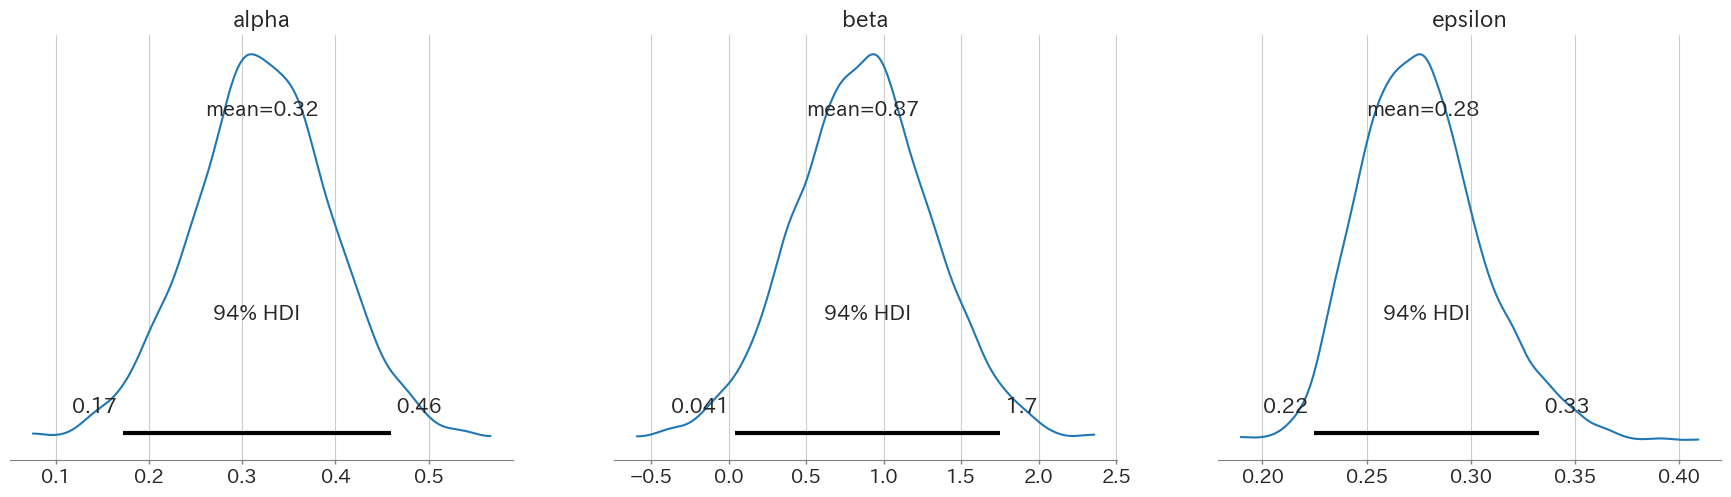

In [16]:
# Sample値から、各Parameter の確率分布を可視化
az.plot_posterior(idata, var_names=['alpha', 'beta', 'epsilon'])
plt.show()

- alpha(傾き): 0.32
- beta(切片):  0.87

程度の値であることを確認。


`idata` には観測値が得られる可能性がある回帰直線の傾きと切片の Pair が Sample数だけ含まれている。
`idata` から回帰直線の傾きと切片の Pair を取り出し、回帰直線を描画する。

In [19]:
# x の２点を NumPy 配列にする
x_values_sepal_length = np.array([x_sepal_length.min() - 0.1, x_sepal_length.max() + 0.1])
print(x_values_sepal_length, x_values_sepal_length.shape)

# Sampling結果から alpha と beta を取り出し shape を加工する
alpha_values = idata['posterior']['alpha'].values.reshape(-1, 1)
beta_values  = idata['posterior']['beta'].values.reshape(-1, 1)

# shape の確認
print(alpha_values.shape, beta_values.shape)

# 2000 Pattern それぞれで、２点の１次関数の計算
y_preds = alpha_values * x_values_sepal_length + beta_values
print(y_preds.shape)

[4.8 7.1] (2,)
(4000, 1) (4000, 1)
(4000, 2)


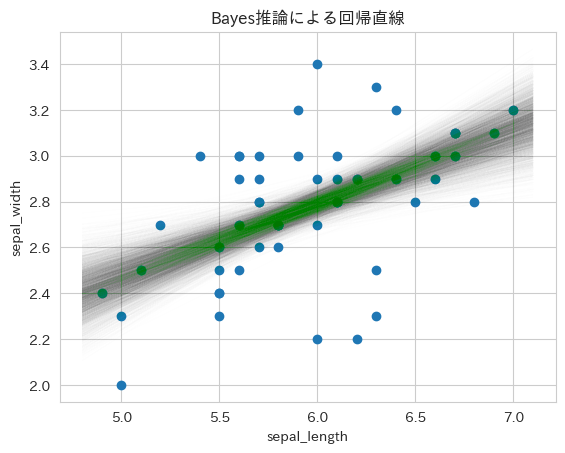

In [21]:
# 散布図と回帰直線の重ね描き
for y_pred in y_preds:
    plt.plot(x_values_sepal_length, y_pred, lw=1, alpha=0.005, c='g')

plt.scatter(x_sepal_length, y_sepal_width)
plt.title('Bayes推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

- 最尤推定などを用いると１本の直線で表現される回帰直線が、幅を持った状態で示される。
- 濃淡は、その近傍に回帰直線が存在する確率の高さを表す。

## 少ない観測値で Bayes推論
Bayes推論は、もっと観測値が少なく、予測にとって厳しい条件で本領を発揮するため、Sample数を３つという少ない状態に減らして実行する。

In [23]:
# 観測値数の絞り込み
import random

random.seed(42)
indexes = range(len(x_sepal_length))
sample_indexes = random.sample(indexes, 3)
print('Index値', sample_indexes)

# Data数を３個にする
x_less_sepal_length = x_sepal_length.iloc[sample_indexes]
y_less_sepal_width = y_sepal_width.iloc[sample_indexes]
print('x の値', x_less_sepal_length.values)
print('y の値', y_less_sepal_width.values)

Index値 [40, 7, 1]
x の値 [5.5 4.9 6.4]
y の値 [2.6 2.4 3.2]


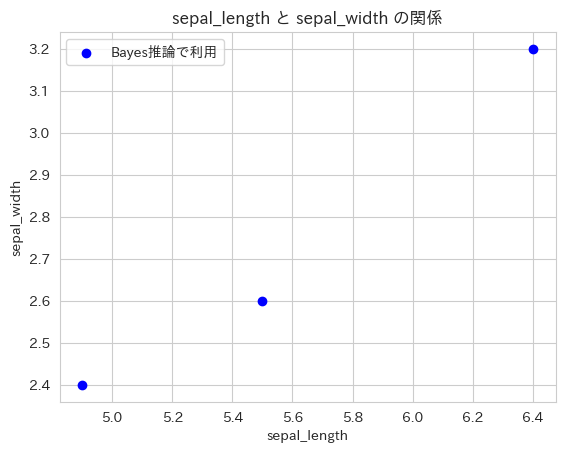

In [24]:
# 抽出した３点の散布図表示
plt.title('sepal_length と sepal_width の関係')
plt.scatter(x_less_sepal_length, y_less_sepal_width, label='Bayes推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

In [26]:
# 確率 Model 定義と Sampling
model_lr_less = pm.Model()

with model_lr_less:
    # 観測値を ConstantData として定義
    x_data_sepal_length = pm.ConstantData('x_data_sepal_length', x_less_sepal_length)
    y_data_sepal_width = pm.ConstantData('y_data_sepal_width', y_less_sepal_width)

    # 確率変数 alpha(１次関数の傾き), beta(１次関数の切片) の定義
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta = pm.Normal('beta', mu=0.0, sigma=10.0)

    # 平均値 mu の計算
    mu = pm.Deterministic('mu', alpha * x_data_sepal_length + beta)

    # 誤差を示す確率変数 epsilon の定義
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # 観測値を持つ確率変数は obs として定義
    obs_sepal_width = pm.Normal('obs_sepal_width', mu=mu, sigma=epsilon, observed=y_data_sepal_width)

    # Sampling
    idata_less = pm.sample(random_seed=42, target_accept=0.995, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


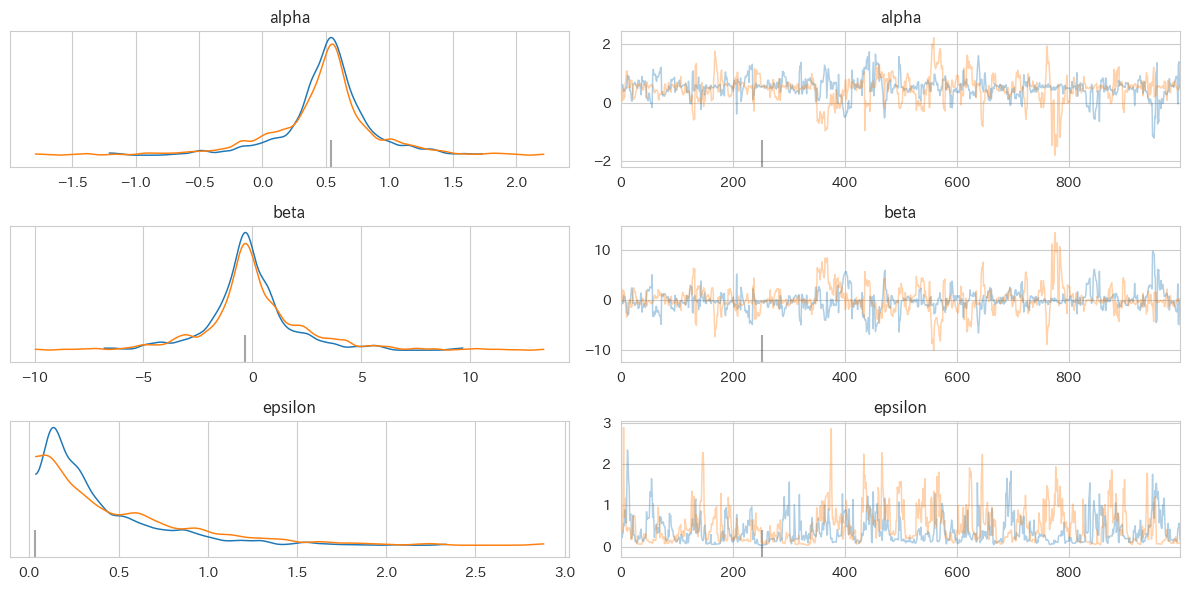

In [27]:
# Bayes推論の正常性の確認
az.plot_trace(idata_less, compact=False, var_names=['alpha', 'beta', 'epsilon'])
plt.tight_layout()
plt.show()

誤差を意味する `epsilon` が時々、大きな値になってしまうが主目的の `alpha` と `beta` に関しては確率密度関数の形状が２つの Sample直系列でほぼ同じとなった。

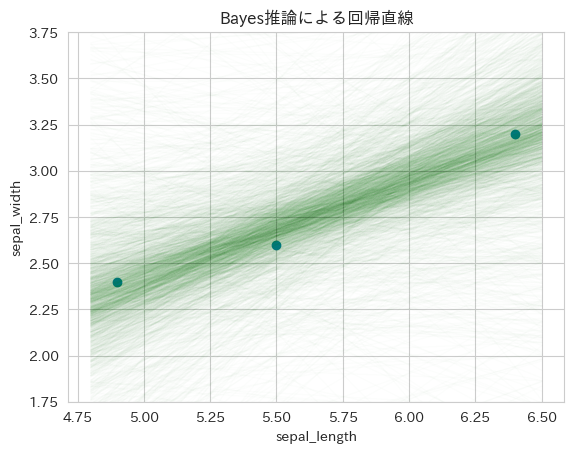

In [28]:
# 散布図と回帰直線を重ねて描く

# X の２点を NumPy 配列にする
x_values_sepal_length = np.array([x_less_sepal_length.min() - 0.1, x_less_sepal_length.max() + 0.1])

# Sample値から alpha と beta を抽出し shape を加工する
alpha_less_values = idata_less['posterior']['alpha'].values.reshape(-1, 1)
beta_less_values = idata_less['posterior']['beta'].values.reshape(-1, 1)

# 2000 Pattern それぞれで、２点の１次関数値の計算
y_preds = alpha_less_values * x_values_sepal_length + beta_less_values

# 2000組の直線を散布図と同時表示
for y_pred in y_preds:
    plt.plot(x_values_sepal_length, y_pred, lw=1, alpha=0.01, c='g')
plt.scatter(x_less_sepal_length, y_less_sepal_width)
plt.ylim(1.75, 3.75)
plt.title('Bayes推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

３個しか観測値がなかったため、回帰直線の分布もぼんやりしている。この条件の場合、いろいろな Pattern の回帰直線が可能性としてありそうなことが Graph から確認できる。